# SAN Assignment - Linear Regression

Author : Šimon Gavula

Email  : gavulsim@fel.cvut.cz

# Introduction
You have already learned that a regression model may suffer from various issues. When constructing such a model, it is important to check for assumptions such as linearity, independence of errors, normality of residuals, homoscedasticity and the absence of multicollinearity. Additionally, there are other potential issues, such as irrelevant variables, which can reduce model performance. In this assignment you will aim to achieve the best possible linear model using the techniques you have already learned.

# Submission
Fill in your name above for clarity.
To solve this homework, simply write your answers into this document and fill in the marked pieces of code.
Submit your solution consisting of both this modified notebook file and the **exported PDF or HTML document** as an archive to the courseware BRUTE upload system for the SAN course.
The deadline is specified there. 

# Initialization

Load the required libraries `numpy`, `pandas`, `scipy`, `seaborn`, `matplotlib` and `statsmodels`; make sure you have those installed.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import matplotlib.pyplot as plt

In [2]:
# A little bit of a nice python implementation of regression diagnostics
# Taken from https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html

# base code
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-v0_8-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


# Input data

In this assignment, you will work with a dataset that contains 200 samples, 10 features x_1,,x_{10} and one dependent variable y. Your general task is to develop the best possible linear model. One that is both simple and interpretable while still performing well. You are expected to correctly interpret the model. Assume that outliers are not expected, and our primary focus is on identifying common trends rather than a few exceptional samples.


In [3]:
data = pd.read_csv("lreg_data.csv")
n_samples = len(data)

In [4]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,104.927460,90.801673,8.245971,14.418621,48.308279,7.065510,61.345984,60.240271,36.056624,-58.976470,135.749790
1,106.064621,131.374489,18.872152,2.005978,66.808003,2.108618,54.098520,51.715321,34.648322,-65.319762,256.367206
2,80.704176,93.445031,14.390614,6.559893,40.730345,4.967853,42.048620,63.090743,39.534903,-72.956452,145.465889
3,106.652376,64.380813,2.806061,11.121180,38.983300,3.951395,71.821374,61.643359,31.758359,-41.604033,74.887862
4,110.257915,129.240903,19.094629,-1.840531,64.720809,7.011817,46.750970,62.022497,41.054772,-50.113179,265.903756


# The full linear model
Let us start with a full linear model. The first task is to evaluate the model based on its fisrt summary. Then, check its assumptions and detect its potential issues. Your task is to evaluate the plots and tests performed below, you should also further develop them (propose their alternatives).  


In [5]:
full_lm = smf.ols('y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10', data=data).fit()
print(full_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     26.13
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           1.00e-30
Time:                        19:40:05   Log-Likelihood:                -1061.7
No. Observations:                 200   AIC:                             2145.
Df Residuals:                     189   BIC:                             2182.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    148.6082     51.087      2.909      0.0

<Axes: title={'center': 'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

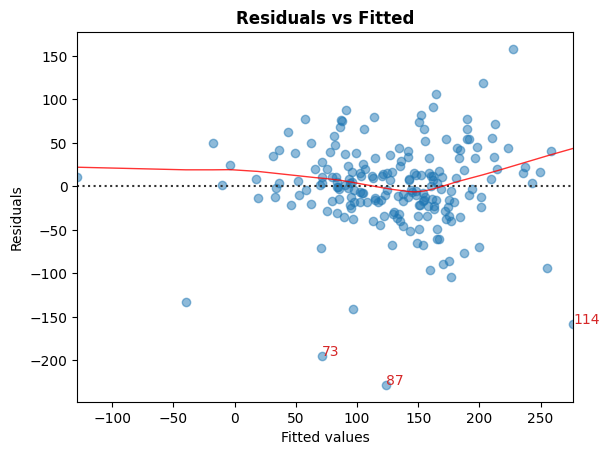

In [6]:
# Residual plot
lm_diag = LinearRegDiagnostic(full_lm)
lm_diag.residual_plot()

In [7]:
# Homoscedasticity test
_, pval, __, ___ = het_breuschpagan(full_lm.resid, full_lm.model.exog)
print(f"Breusch-Pagan p-value: {pval}")

Breusch-Pagan p-value: 0.00012628123768207756


<Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

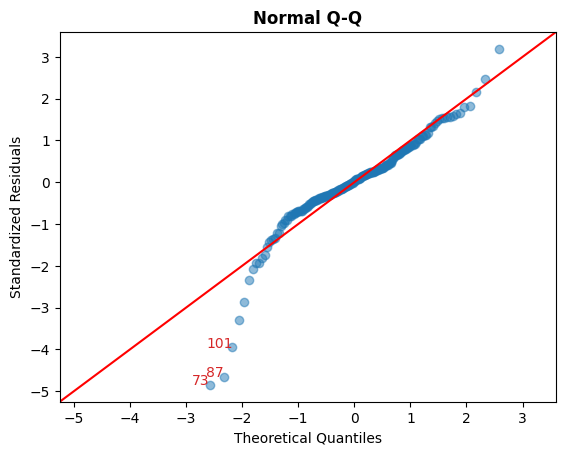

In [8]:
# Normality of residuals - Q-Q plot and Shapiro-Wilk test
lm_diag.qq_plot()

In [9]:
print(shapiro(full_lm.resid))

ShapiroResult(statistic=np.float64(0.937453919986838), pvalue=np.float64(1.3840774364977536e-07))


Outliers: [ 51  73  86  87  97 101 114 128 132 159 164]


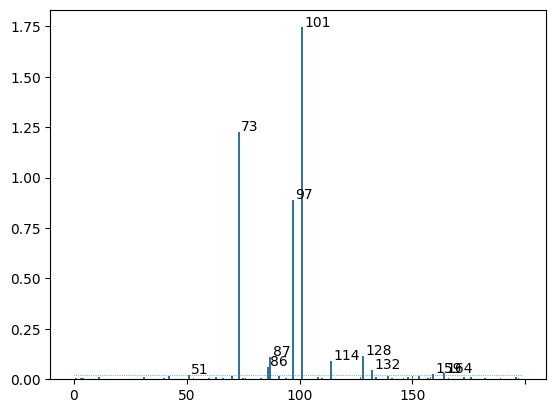

In [10]:
# Outliers detection using Cook's distance
influence = full_lm.get_influence()
cooks_d = influence.cooks_distance[0]
outliers = np.where(cooks_d > 4 / len(data))[0]
print(f"Outliers: {outliers}")

x=np.arange(n_samples)
ax = sns.barplot(y=cooks_d, x=x)
ax.plot(x, np.full(n_samples, 4 / len(data)), linestyle="dotted", linewidth=0.5)
for o in outliers:
    ax.text(x[o] + 1, cooks_d[o] + 0.005, str(o))
ax.set_xticks(range(0, 250, 50))
plt.show()

In [11]:
# Variance Inflation Factor for multicollinearity detection
lm_diag.vif_table()

,Features,VIF Factor
6,x6,1.03
7,x7,1.04
9,x9,1.05
10,x10,1.05
1,x1,1.06
8,x8,1.54
4,x4,2.14
3,x3,2.42
5,x5,10.21
2,x2,10.27


### **Add your verbal summary here (1p)**:

### **Model summary**
The full linear regression model explains approximately 58% of the variance in the response variable (R² = 0.580, adjusted R² = 0.558). The overall F-statistic (26.13, p < 1e-30) indicates that at least one predictor significantly contributes to the model and suggesting a significant relationship between predictors and the outcome.

#### **Assamption checks**
**Linearity** <br>
Residuals plot: shows visible patterns, suggesting non-linearity.<br>
**Independence of errors**<br>
Not tested<br>
**Normality of residuals**<br>
QQ plot: deviations from the diagonal suggesting non-normality of residuals.<br>
Shapiro–Wilk test: p-value = 1.38e-07 which suggests residuals are not normally distributed.<br>
**Homoscedasticity**<br>
Breusch–Pagan test: p-value = 0.00013 which suggests residuals are heteroscedastic.<br>
**Multicollinearity**<br>
Variables x2 (VIF = 10.27) and x5 (VIF = 10.21) exceed the common threshold of 10 which indicating high multicollinearity.<br>
**Influential points**<br>
The most influential points are observations 73, 97, and 101, with Cook’s distance values around 0.75–1.75, suggesting removing.<br>

#### **Conclusion**
Although the model explains a moderate amount of variance (58%), the presence of heteroscedasticity (Breusch–Pagan test), non-normal residuals (QQ plot and Shapiro-Wilk test), and multicollinearity (Variance Inflation Factor method) indicates that the model violates several linear regression assumptions and should be improved.

#### **Suggested improvements**
1. Removing predictors with high multicollinearity (x2 and x5).
2. Simplify the model by removing predictors with high p-values; with only 10 predictors, the expected false rejection rate (≈0.5) remains acceptably low.
3. Removing the most influation points.


# Remove the issues from the full model

Now deal with the detected issues. Build an alternative model and show that it works better than the full model. Finally, verbally justify all the decisions that you made and explain their effects.

In [12]:
# Indices of influential observations
influential_points = [51, 73, 86, 87, 97, 101, 114, 128, 132, 159, 164] 
# Remove them from the dataset
data_cleaned = data.drop(index=influential_points).reset_index(drop=True)
n_sample_cleaned = len(data_cleaned)

In [13]:
#### add your code here (1p) ####

# Remove predictors
# reduced_lm = smf.ols("y ~ x1 + x2 + x3 + x4 + x6 + x7 + x8 + x9 + x10", data=data_cleaned).fit()
# reduced_lm = smf.ols("y ~ x1 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10", data=data_cleaned).fit() # adj. r-square 0.699
# reduced_lm = smf.ols("y ~ x1 + x3 + x5 + x6 + x7 + x8 + x9 + x10", data=data_cleaned).fit() # adj. r-square 0.701
# reduced_lm = smf.ols("y ~ x1 + x3 + x5 + x6 + x8 + x9 + x10", data=data_cleaned).fit() # adj. r-square 0.702
reduced_lm = smf.ols("y ~ x1 + x3 + x5 + x8 + x9", data=data_cleaned).fit() # adj. r-square 0.704
print(reduced_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     90.21
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           1.69e-47
Time:                        19:40:06   Log-Likelihood:                -934.67
No. Observations:                 189   AIC:                             1881.
Df Residuals:                     183   BIC:                             1901.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     90.0745     37.226      2.420      0.0

<Axes: title={'center': 'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

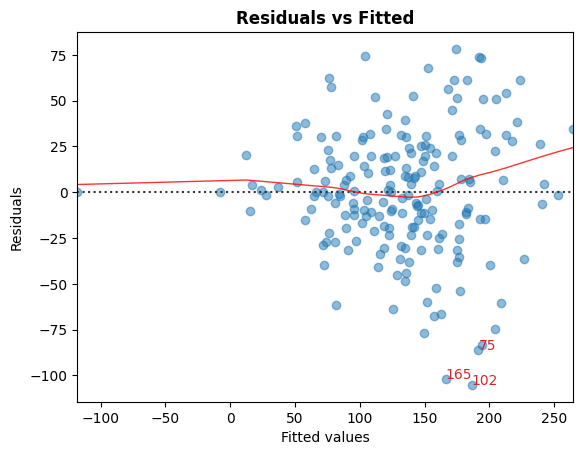

In [14]:
lm_diag_red_lm = LinearRegDiagnostic(reduced_lm)
lm_diag_red_lm.residual_plot()

In [15]:
_, pval, __, ___ = het_breuschpagan(reduced_lm.resid, reduced_lm.model.exog)
print(f"Breusch-Pagan p-value: {pval}")

Breusch-Pagan p-value: 3.865554613731106e-06


<Axes: title={'center': 'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

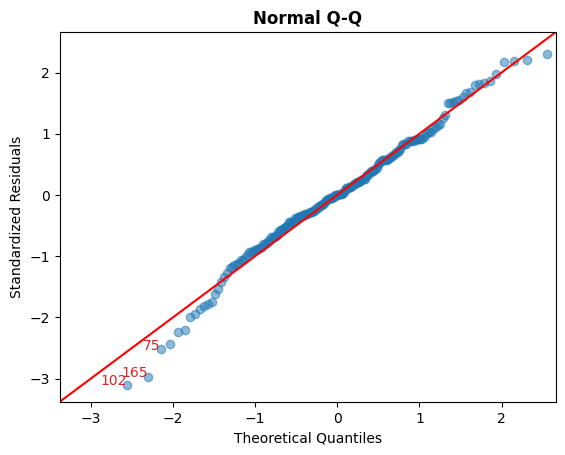

In [16]:
# Normality of residuals - Q-Q plot and Shapiro-Wilk test
lm_diag_red_lm.qq_plot()

In [17]:
print(shapiro(reduced_lm.resid))

ShapiroResult(statistic=np.float64(0.9874736279637005), pvalue=np.float64(0.09313232499141251))


Outliers: [  4  42  59  75  81  87  96 102 125 130 144 158 162 165 185]


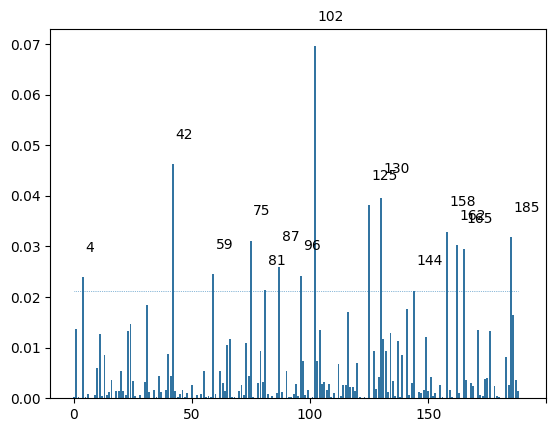

In [18]:
# Outliers detection using Cook's distance
influence = reduced_lm.get_influence()
cooks_d = influence.cooks_distance[0]
outliers = np.where(cooks_d > 4 / len(data_cleaned))[0]
print(f"Outliers: {outliers}")

x=np.arange(n_sample_cleaned)
ax = sns.barplot(y=cooks_d, x=x)
ax.plot(x, np.full(n_sample_cleaned, 4 / len(data_cleaned)), linestyle="dotted", linewidth=0.5)
for o in outliers:
    ax.text(x[o] + 1, cooks_d[o] + 0.005, str(o))
ax.set_xticks(range(0, 250, 50))
plt.show()

In [19]:
# Variance Inflation Factor for multicollinearity detection
lm_diag_red_lm.vif_table()

,Features,VIF Factor
2,x3,1.01
4,x8,1.01
3,x5,1.03
5,x9,1.04
1,x1,1.04
0,Intercept,219.36


### **Add your verbal summary here (1p)**:

#### **Model improvements**
- Reduced the number of predictors and removed outliers from dataset.
- Excluded predictors with high p-values in individual t-tests and with hight VIF value.
- Removed data points with high Cook’s distance.
- Improved model performance: R-squared increased from 0.580 to 0.711 and adjusted R-squared from 0.558 to 0.704, explaining approximately 71% of variance.
- Multicollinearity is no longer an issue - VIF factor of all predictors is close to 1.
- Residual normality improved: Shapiro–Wilk p-value increased from 1.38e-07 to 0.093, indicating residuals are now approximately normally distributed; QQ-plot shows a more diagonal pattern.

#### **What did not improve**
1. Linearity: residuals plot still shows visible patterns, suggesting non-linearity
2. Homoscedasticity: p-value went from 0.00013 to 3.87e-06 indicating residuals are still heteroscedastic. 

# Feature selection

Now, the goal is to run feature selection and remove irrelevant variables. Compare several different feature selection methods and pick one of them. Demonstrate that feature selection applied to the full model brings very different results than in the alternative model without issues. At the end, explain the model.


To see, how you can achieve regularization of your model refer to [documentation](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html#statsmodels.regression.linear_model.OLS.fit_regularizeddocumentation).
LASSO could be implemented, for example, by:
```
model = sma.OLS(endog=y, exog=X)
fit = model.fit_regularized(alpha=a, L1_wt=1) 
```
Note, that you need to set two parameters: alpha, but also L1_wt, which switches different kinds of regularization.


In [20]:
#### add your code here (1p) ####

In [21]:
def forward_selection(input_features, data):
    features = input_features.copy()
    final_model = []
    final_value = float('-inf')

    while True:
        max_value = float('-inf')
        final_feature = None
        for feature in features:
            temp_features = final_model.copy() + [feature]
            model_formula = "y ~ " + " + ".join(temp_features)
            model = smf.ols(model_formula, data=data).fit()
            curr_adj_r2 = model.rsquared_adj
            if curr_adj_r2 > max_value:
                max_value = curr_adj_r2
                final_feature = feature
        if final_feature is None or max_value < final_value:
            break
        final_model.append(final_feature)
        features.remove(final_feature)
        final_value = max_value

    final_formula = "y ~ " + " + ".join(final_model)
    final_model_fit = smf.ols(final_formula, data=data).fit()
    return final_model_fit

def backward_selection(features, data):
    final_model = features.copy()
    final_value = float('-inf')

    model_formula = "y ~ " + " + ".join(features)
    model = smf.ols(model_formula, data=data).fit()
    curr_adj_r2 = model.rsquared_adj

    if curr_adj_r2 > final_value:
        final_value = curr_adj_r2

    while True:
        max_value = float('-inf')
        final_feature = None
        for feature in final_model:
            temp_features = final_model.copy()
            temp_features.remove(feature)
            model_formula = "y ~ " + " + ".join(temp_features)
            model = smf.ols(model_formula, data=data).fit()
            curr_adj_r2 = model.rsquared_adj
            if curr_adj_r2 > max_value:
                max_value = curr_adj_r2
                final_feature = feature
        if final_feature is None or max_value < final_value:
            break
        final_model.remove(final_feature)
        final_value = max_value
    
    final_formula = "y ~ " + " + ".join(final_model)
    final_model_fit = smf.ols(final_formula, data=data).fit()
    return final_model_fit


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

def lasso(data):
    y = data["y"]
    X = data.drop("y", axis=1)

    # Standardize predictors
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Add constant for intercept
    X_scaled = sm.add_constant(X_scaled)

    # Choose alpha and L1_wt using cross-validation
    elastic_cv = ElasticNetCV(
        cv=5,
        random_state=42,
        l1_ratio=np.linspace(0.01, 1.0, 11),
        alphas=100,
        max_iter=10000
    ).fit(X_scaled.drop("const", axis=1), y)

    alpha_value = elastic_cv.alpha_
    L1_wt_value = elastic_cv.l1_ratio_

    lasso_model_full = sm.OLS(y, X_scaled)
    lasso_full_fit = lasso_model_full.fit_regularized(method='elastic_net', alpha=alpha_value, L1_wt=L1_wt_value)

    params_cleaned = lasso_full_fit.params
    selected_features_lasso = params_cleaned[params_cleaned != 0].index.tolist()

    formula_from_lasso = 'y ~ ' + ' + '.join([f for f in selected_features_lasso if f != "const"])
    lasso_model = smf.ols(formula_from_lasso, data=data).fit()

    return lasso_model



In [23]:
# Testing methods of feature selection for data dataset

features = data.columns.tolist()
features.remove("y")

fs_model = forward_selection(features, data)
bs_model = backward_selection(features, data)
lasso_model = lasso(data)

print("Forward selection model:")
print(fs_model.summary())

print("")

print("Backward selection model:")
print(bs_model.summary())

print("")

print("Lasso selection model:")
print(lasso_model.summary())

Forward selection model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     43.92
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           1.35e-33
Time:                        19:40:10   Log-Likelihood:                -1062.4
No. Observations:                 200   AIC:                             2139.
Df Residuals:                     193   BIC:                             2162.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    116.0009     3

In [24]:
# Testing methods of feature selection for data_cleand dataset

features = data_cleaned.columns.tolist()
features.remove("y")

fs_model = forward_selection(features, data_cleaned)
bs_model = backward_selection(features, data_cleaned)
lasso_model = lasso(data_cleaned)

print("Forward selection model:")
print(fs_model.summary())

print("")

print("Backward selection model:")
print(bs_model.summary())

print("")

print("Lasso selection model:")
print(lasso_model.summary())

Forward selection model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     90.21
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           1.69e-47
Time:                        19:40:11   Log-Likelihood:                -934.67
No. Observations:                 189   AIC:                             1881.
Df Residuals:                     183   BIC:                             1901.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     90.0745     3

### **Add your verbal summary here (1p)**:

Three different feature selection methods were employed to identify the optimal set of predictors for the linear model: forward selection, backward selection, and LASSO regularization. These methods were applied to both the original dataset and the cleaned dataset (from which outliers were removed).

**Forward and backward selection**
- The result is that the forward and backward selection selected same model for data and also same model for data_clean dataset. 
- For data dataset the model is: y ~ x2 + x4 + x5 + x8 + x9 + x10 with R-squared 0.577 and adj. R-squared: 0.564. 
- For data cleaned dataset the model is: y ~ x1 + x3 + x5 + x8 + x9 with R-squared 0.711 and adj. R-squared: 0.704.

**Lasso method**
- Lasso method select worse model in both cases. 
- For data dataset it selected model: y ~ x1 + x2 + x3 + x4 + x5 + x7 + x8 + x9 + x10 with R-squared: 0.580 and adj. R-squared: 0.560. 
- For data cleaned dataset it selected model: y ~ x1 + x2 + x3 + x4 + x5 + x7 + x8 + x9 + x10 with R-squared: 0.716 and adj. R-squared: 0.700.

**Selecting model**
- I will select the model generated by Backward (Forward) Selection on the cleaned data.
- It achieved the highest adjusted R-squared (0.704) and corresponds to the same model that was manually selected in the second part so the interpretation is the same.


## Grading 
+ 1p for selection of proper methods for assumption verification and their explanation
+ 1p for the correct implementation of issue removal
+ 1p for its explanation and right decisions in further model design themselves
+ 1p for proper application of feature selection techniques and their comparison 
+ 1p for comprehensive evaluation of all the model improvements and the final wrap up

## Feedback
Was some part of the notebook unclear, would any topic need more attention during the tutorials? 
If you want to leave us feedback on the assignment, we would be happy to hear it. 
Here is your space: